# Modeling a Binary Star Population

## Intro
The Kepler satellite found a population of 27 stars rotating faster than expected for single stars.  After an initial analysis of the rapidly rotating stars with more detailed observations was inconclusive, we decided to build a more sophisticated model in Python.

This model aims to test the hypothesis that these rapidly rotating stars exhibits characteristics of spectroscopic binary systems influenced by tidal locking interactions.In a binary system, two objects orbit a common center of mass, bound together by gravity.

## Known Parameters

The known quantities of these stars include their rotational period acquired from McQuillan et al (2014) and the mass acquired from Berger et al (2020). Additionally, radial velocity measurements were collected using the Modspec instrument at the Michigan-Dartmouth-MIT (MDM) observatory.

In [11]:
from astropy.table import Table, join
import astropy.io.ascii as ascii
import astropy.io.fits
import warnings
from astropy import constants as const

# Suppress warnings:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

#Data Sources
KIC_CSV = 'MDM_targets.csv'
MRT1_FILE ='ajab8a33t1_mrt.txt'
MRT2_FILE = 'ajab8a33t2_mrt.txt'
MCQ_FILE = 'McQuillan.fit'
RV_PICKLE = 'full_rvs.pickle'

#Constants
Gravitational_constant = const.G # Value = 6.67 x 10^-11 m^3/(kg s^2)
SUN_MASS = const.M_sun # Value = 1.98840987e+30 kg

def read_data():
    targets = Table.read(KIC_CSV, format = 'ascii.csv')
    targets.rename_column('ï»¿KIC', 'KIC')
    data_set1 = Table.read(MRT1_FILE, format = 'ascii.mrt')
    data_set2 = Table.read(MRT2_FILE, format = 'ascii.mrt')
    McQuillan = Table.read(MCQ_FILE, format = 'fits')
    
    #Join the datasets
    d1_d2 = join(data_set1, data_set2)
    targets = join(targets, d1_d2)
    table = join(targets, McQuillan, join_type = 'left', keys = 'KIC')
    
    return table

#Save table to a CSV file
def write_data():
    table = read_data()
    table.write('Target_data.csv', format = 'ascii.csv')

#Read saved table
def read_table():
    return Table.read('Target_data.csv')

#Create an index for KIC targets
def KIC_index():
    table = read_data()
    index = table['KIC']
    
    return index

import pickle
#Get observation times and radial velocities
def rv_times(KIC_number):
    with open(RV_PICKLE, 'rb') as f:
        docs, full_rvs = pickle.load(f)
    KIC_times, KIC_rvs = full_rvs[f"KIC{KIC_number}"]
    
    return KIC_times, KIC_rvs

#Target Mass
def target_mass(KIC_number):
    table = read_table()
    target_mass = table['KIC', 'Mass']
    target_mass.add_index('KIC')
    mass = target_mass.loc[KIC_number]['Mass']
    
    return mass

#Target Orbital Period
def target_period(KIC_number):
    table = read_table()
    target_period = table['KIC', 'Prot']
    target_period.add_index('KIC')
    Prot = target_period.loc[KIC_number]['Prot']
    
    return Prot


## Modeled Unknown Parameters

The modeled unknown parameters include the inclination angle, mass ratio (q), and phase angle (theta).

Inclination Angle:

The inclination angle is the angle between the plane of the orbit and the observer. The inclination angle of the binary orbit follows a sine distribution, this is because there’s almost an infinite number of ways to have a 90 degree inclination angle but there are only two ways of getting a 0 degree inclination angle.

Mass Ratio (q):

The mass ratio is the mass of the primary star divided by the mass of the secondary star. The mass ratio follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 1. 

Phase Angle (Theta):

The phase angle is the angle at which the first observation was made. The phase angle follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 2π. 


In [12]:
import numpy as np
from math import pi
from astropy import units as u

# Inclination angle
def sin_distn():
    rand_uniform_array = np.random.uniform(0, pi/2, 200)
    i_angle = np.arccos((2 * rand_uniform_array)/pi)
    
    return i_angle
    
inc_angle_array = sin_distn()

# Mass ratio (primary mass / companion mass)
q_array = np.random.uniform(0,1, 200)


#Phase angle
theta_array = np.random.uniform(0,2*pi, 200) * u.radian

## Astronomy Functions

Using Kepler's Third Law of planetary motion, the time needed to complete an orbit squared is proportional to the semi-major axis of orbit cubed. Below is a function to calculate the amplitude (semi-major axis) of the binary system. 

In [13]:
from astropy import constants as const

# Amplitude (semi-major axis)
def calculate_amplitude(m1, q_array, incl_angle_array, period):
    m2 = m1 * q_array
    orbital_period = (period * u.day).to(u.second)
    total_m = m1 + m2
    amplitude = (
        ( 
        ((m2**3) / (total_m**2))
        * (np.sin(inc_angle_array)**3)
        *((2 * pi * Gravitational_constant) / orbital_period)
        )
        **(1/3)
        )
    return amplitude # units of m/s7713


In astronomy, radial velocity is an object’s motion towards or away from the observer. Using Kepler’s 3rd law of planetary motion, we created functions to calculate radial velocity, and add noise to account for errors in observations.

In [14]:
# Radial velocity
def calculate_radial_velocity(m1, q_array, time_array, period , theta_array, inc_angle_array):
    time_array = time_array.reshape(len(time_array), 1, 1, 1) 
    theta_array = theta_array.reshape(1, len(theta_array), 1, 1)
    q_array = q_array.reshape(1, 1, len(q_array),1)
    inc_angle_array = inc_angle_array.reshape(1, 1, 1, len(inc_angle_array))
    
    amplitude = calculate_amplitude(m1, q_array, inc_angle_array, period)
    period =  period * u.day
    omega = (2*pi)/(period.to(u.second))
    radial_velocity = (
        (amplitude * np.cos(((omega * time_array).to(u.radian, equivalencies = u.dimensionless_angles())) + theta_array))
    ) #units of m/s
    
    return radial_velocity # in m/s

# Add noise to radial velocity
def calculate_velocity_with_noise(m1, q_array, time_array, period, std, theta_array, inc_angle_array):
    radial_velocity_array = calculate_radial_velocity(m1, q_array, time_array, period,theta_array,inc_angle_array) #m/s
    noise = np.random.normal(0, std, size = radial_velocity_array.shape)  * (u.km/u.second)
    velocity_with_noise = radial_velocity_array + noise
    
    return (velocity_with_noise.to(u.km/u.s)) 


With the known and modeled parameters, our model can generate an array of radial velocities for each possible combination of parameters. However, one limitation of this research was the computational constraints of my computer.

In [15]:

def generate_rv_array(KICnumber):
    time_array, measured_rv = rv_times(KICnumber)
    time_array = np.array(time_array) *u.day
    measured_rv = np.array(measured_rv) * (u.km/u.s)
    std = 10 # standard deviation in km/s
    mass = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber) 
    rv_array = calculate_velocity_with_noise(mass, q_array, time_array, t_period, std, theta_array, inc_angle_array) #m/sec
    
    return rv_array # in km/s

Our model used a Chi-square statistical test to identify the best-fit radial velocity curve that best fits the motion of a binary star system. We then compare this modeled radial velocity curve with the actual radial velocity measurements obtained using the Modspec instrument at the Michigan-Dartmouth-MIT (MDM) Observatory.

In [16]:
def Chi_square_distribution(KICnumber):
    radial_velocities = generate_rv_array(KICnumber)
    time_array,measured_rv = rv_times(KICnumber)
    measured_rv = measured_rv * (u.km/u.s) #measured rv
    measured_rv = measured_rv.reshape(len(measured_rv), 1, 1, 1)
    chi_square = ((radial_velocities - measured_rv)**2) / ((10* u.km/u.s)**2)
    chi_values_array = np.sum(chi_square, axis = 0)
    
    return chi_values_array

In [17]:
def minimum(KICnumber):
    chi_values = Chi_square_distribution(KICnumber)
    min_value = chi_values.min() #returns the minimum value in the multidimensional array s
    max_value = chi_values.max()
    min_index = np.argwhere(chi_values == min_value)
    
    theta_value = theta_array[min_index[0][0]]
    q_value = q_array[min_index[0][1]]
    i_value = inc_angle_array[min_index[0][2]]
    
    print(f"KIC target: KIC_{KICnumber}")
    print("max value is ", max_value)
    print("min value is ", min_value)
    print("theta value is ", theta_value)
    print("q value is ", q_value)
    print("inclination angle value is ", i_value)
    
    return [theta_value,q_value,i_value,min_value]

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def KIC_Model(KICnumber):
    #Declare paramters
    time_array, measured_rv = rv_times(KICnumber) 
    time_array = np.array(time_array) *u.day
    m1 = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber)
    
    #Find minimum Chi-Square value and respective modeled parameters
    min_ = minimum(KICnumber)
    b_f_theta = np.array([min_[0].value]) * u.radian
    b_f_q = np.array([min_[1]])
    b_f_i = np.array([min_[2]])
    min_chi_value = np.array([min_[3]])
    #print(b_f_theta,b_f_q,b_f_i)

    #Hypothesis testing
    print('Experimental p value = ', min_chi_value)
    right_tail_value = stats.chi2.ppf(1-0.025, df = 2)#we use 2 degrees of freedom since we have 3 categories of modeled parameters, dof = n-1 = (theta, q, inc_angle) - 1
    print('Theoretical p value =', right_tail_value)
    if min_chi_value < right_tail_value:
        print('We have a binary system')
    elif min_chi_value > right_tail_value:
        print('We do not have a binary system')
    print("")

    
    #calculate best fit curve radial velocity and plot it with measured rv
    b_f_rv = calculate_radial_velocity(m1, b_f_q, time_array, t_period, b_f_theta, b_f_i)
    sns.set()
    ax = plt.axes()
    ax.set(xlabel = 'time (days)', ylabel = 'radial velocity (km/sec)',
           title = f"KIC_{KICnumber} observed & measured rvs")
    plt.plot(time_array, (b_f_rv[:,0,0,0].to(u.km/u.s)).value, label = 'best fit rv curve', linestyle = ':')
    plt.plot(time_array,measured_rv, label = 'measured rv', linestyle = '-')
    plt.legend()
    plt.show()
    

index = KIC_index()

In [19]:
def Binary_Model():
    for i in index:
        KIC_Model(i)

## Results

One of the primary limitations of this research was the computational power and memory constraints of my system. To achieve more accurate results, the model would need to be run on a supercomputer or a high-performance computing system with significantly greater processing capabilities.

KIC target: KIC_1570924
max value is  1122.6844439493548
min value is  6.643847058208543
theta value is  1.3432849097740602 rad
q value is  0.16562354680884261
inclination angle value is  0.4758653198716688
Experimental p value =  [6.64384706]
Theoretical p value = 7.377758908227871
We have a binary system



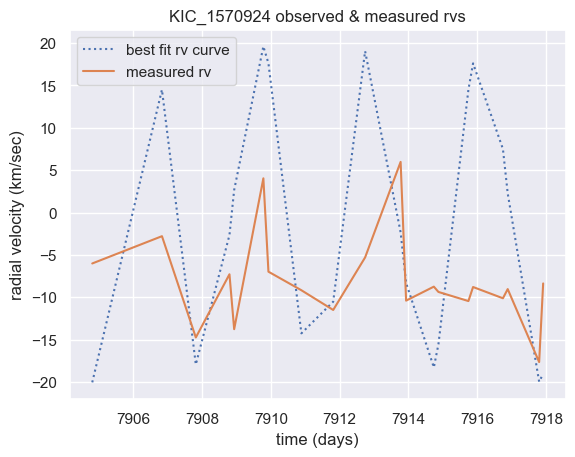

KIC target: KIC_3248885
max value is  1215.771472815891
min value is  104.46263102823083
theta value is  5.988531593950918 rad
q value is  0.148781043408875
inclination angle value is  0.7695137718975108
Experimental p value =  [104.46263103]
Theoretical p value = 7.377758908227871
We do not have a binary system



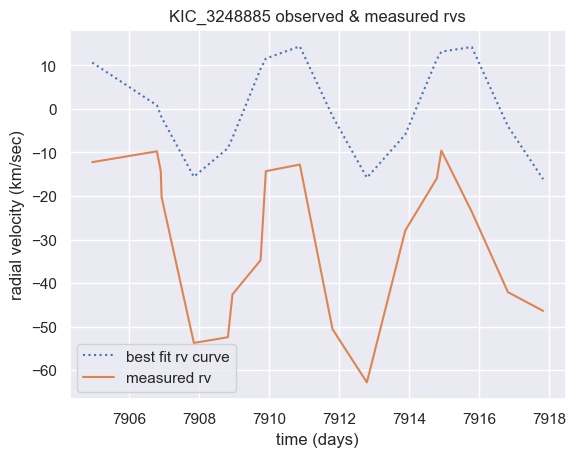

KIC target: KIC_3539632
max value is  1176.3732357533738
min value is  20.40759825918543
theta value is  2.3705245492158538 rad
q value is  0.07242599586629173
inclination angle value is  1.5059177112759818
Experimental p value =  [20.40759826]
Theoretical p value = 7.377758908227871
We do not have a binary system



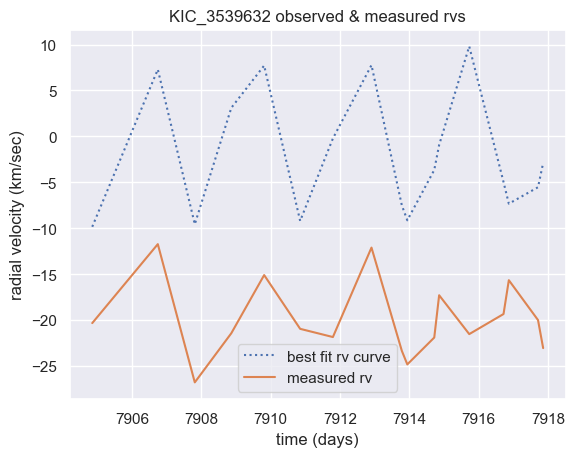

KIC target: KIC_3540728
max value is  1434.4642509049388
min value is  33.237834129183845
theta value is  5.426917815775557 rad
q value is  0.03155159242670591
inclination angle value is  0.8341942348075202
Experimental p value =  [33.23783413]
Theoretical p value = 7.377758908227871
We do not have a binary system



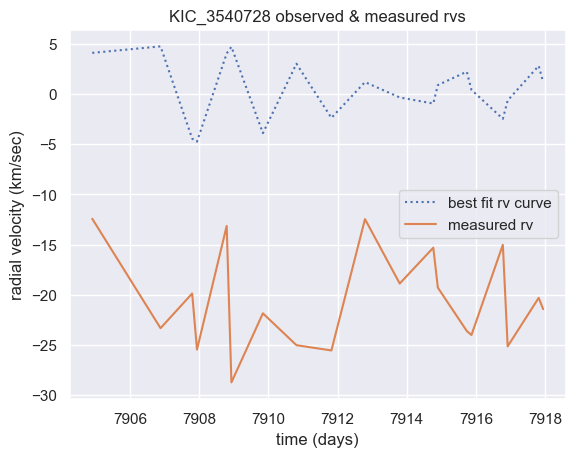

KIC target: KIC_4036736
max value is  1141.1716030410141
min value is  31.724977644524444
theta value is  4.768300660992985 rad
q value is  0.5114416242361637
inclination angle value is  0.21005054732366793
Experimental p value =  [31.72497764]
Theoretical p value = 7.377758908227871
We do not have a binary system



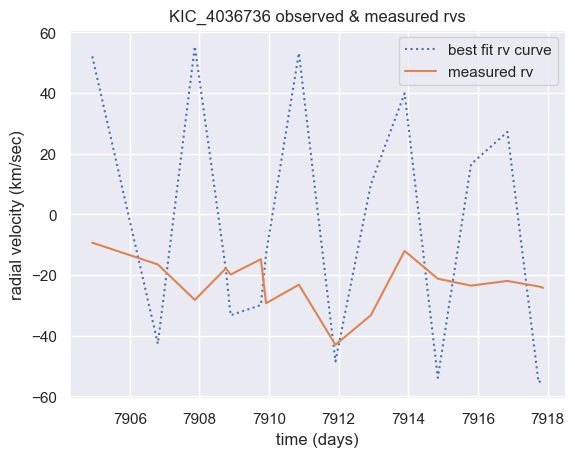

KIC target: KIC_4249702
max value is  928.0388085792075
min value is  31.497705528442307
theta value is  3.007560788796061 rad
q value is  0.07460119350470973
inclination angle value is  1.2496528228681971
Experimental p value =  [31.49770553]
Theoretical p value = 7.377758908227871
We do not have a binary system



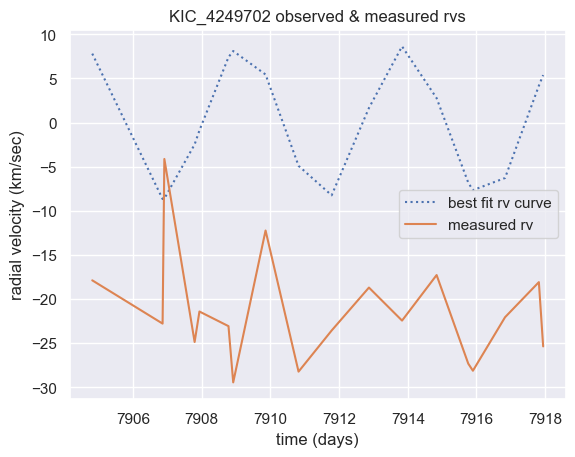

KIC target: KIC_4454890
max value is  1651.5693589176415
min value is  42.395734640530094
theta value is  3.050936728258106 rad
q value is  0.09108824289588036
inclination angle value is  1.3832277636730415
Experimental p value =  [42.39573464]
Theoretical p value = 7.377758908227871
We do not have a binary system



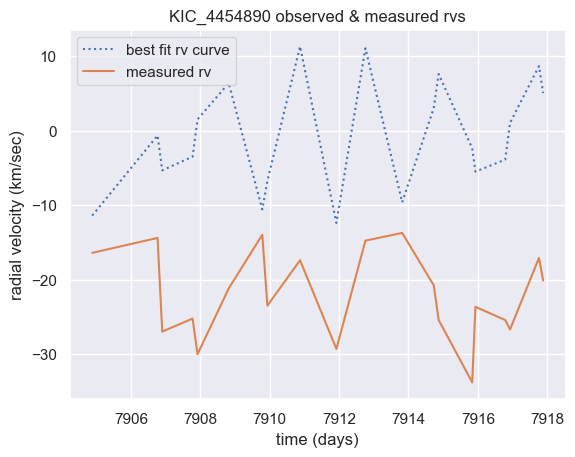

KIC target: KIC_4480434
max value is  1137.4839000950542
min value is  60.966666512348816
theta value is  4.813193801932693 rad
q value is  0.1784846492025849
inclination angle value is  0.34485610214959217
Experimental p value =  [60.96666651]
Theoretical p value = 7.377758908227871
We do not have a binary system



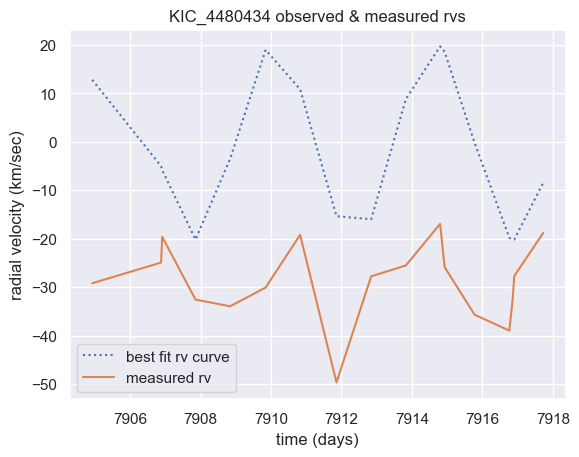

KIC target: KIC_5213142
max value is  1169.56177180249
min value is  3.7728450553908486
theta value is  0.8135844430254432 rad
q value is  0.03155159242670591
inclination angle value is  1.3070108308098338
Experimental p value =  [3.77284506]
Theoretical p value = 7.377758908227871
We have a binary system



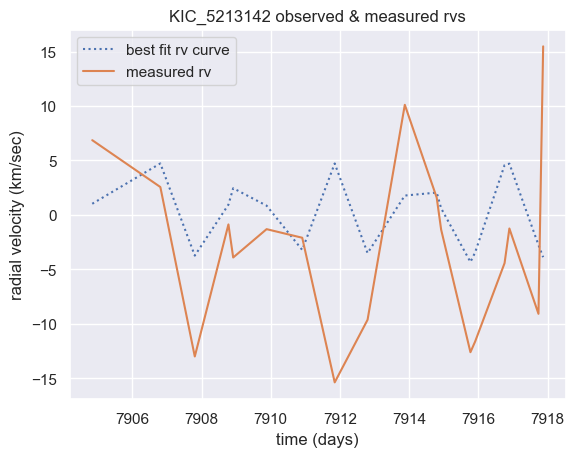

KIC target: KIC_5553362
max value is  1083.5378565492656
min value is  27.01248568131353
theta value is  2.3303216551733463 rad
q value is  0.0725141546367275
inclination angle value is  1.325188422192735
Experimental p value =  [27.01248568]
Theoretical p value = 7.377758908227871
We do not have a binary system



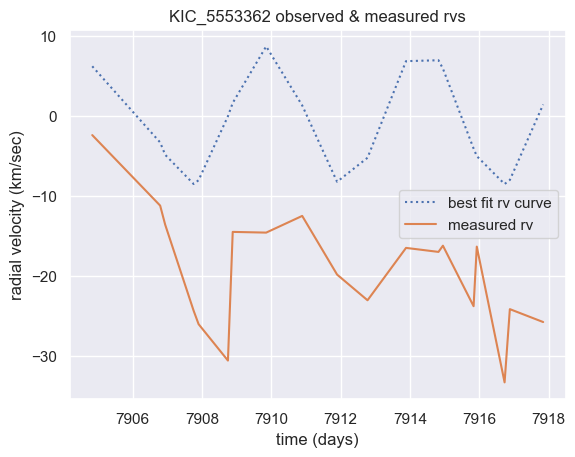

KIC target: KIC_6425783
max value is  1054.62160493832
min value is  55.74609611224925
theta value is  4.100656829540041 rad
q value is  0.4572442841279455
inclination angle value is  0.41122312007719297
Experimental p value =  [55.74609611]
Theoretical p value = 7.377758908227871
We do not have a binary system



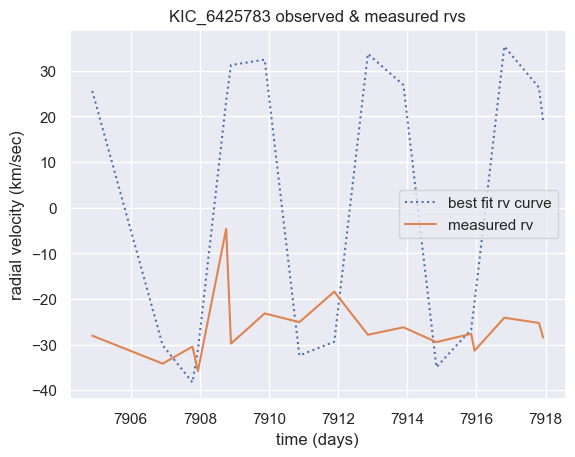

KIC target: KIC_6780052
max value is  1216.547713023631
min value is  30.569265493426084
theta value is  4.100656829540041 rad
q value is  0.08054236506673973
inclination angle value is  1.3867611734476932
Experimental p value =  [30.56926549]
Theoretical p value = 7.377758908227871
We do not have a binary system



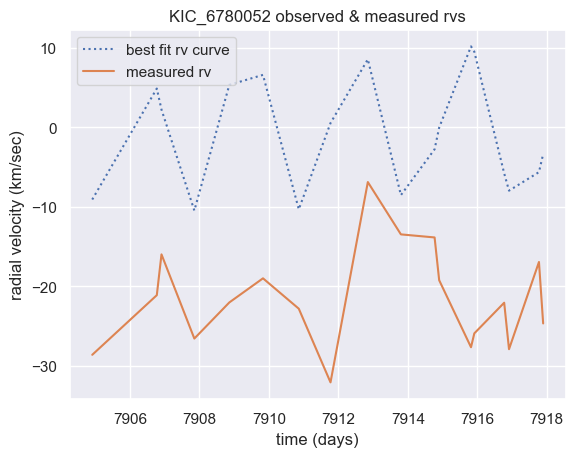

KIC target: KIC_6844101
max value is  1401.5622396693325
min value is  40.07766926495564
theta value is  4.768300660992985 rad
q value is  0.2166043610295113
inclination angle value is  0.38438364739073283
Experimental p value =  [40.07766926]
Theoretical p value = 7.377758908227871
We do not have a binary system



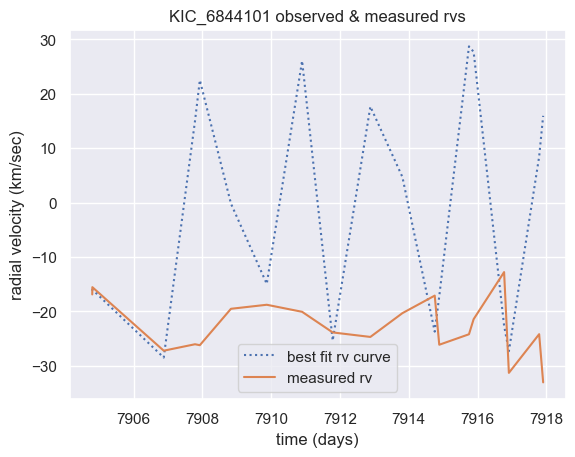

KIC target: KIC_7421325
max value is  920.0208757019001
min value is  10.260623884305845
theta value is  1.0174149696035264 rad
q value is  0.1666685001132714
inclination angle value is  0.779764480881945
Experimental p value =  [10.26062388]
Theoretical p value = 7.377758908227871
We do not have a binary system



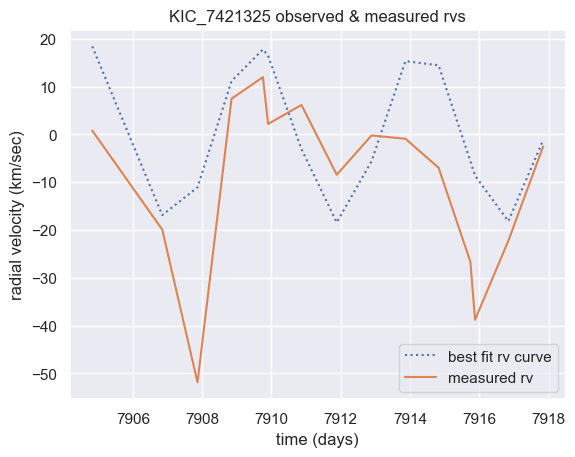

KIC target: KIC_7919763
max value is  1102.6243043221564
min value is  23.271986968690452
theta value is  3.6590241144849407 rad
q value is  0.0685682503440983
inclination angle value is  1.029163398774042
Experimental p value =  [23.27198697]
Theoretical p value = 7.377758908227871
We do not have a binary system



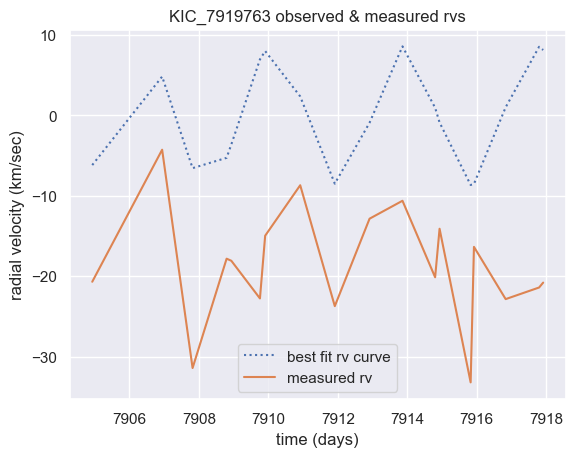

KIC target: KIC_8442720
max value is  1325.0835054692025
min value is  189.8068450430586
theta value is  6.176395331424988 rad
q value is  0.025252983218498337
inclination angle value is  1.3010389798238269
Experimental p value =  [189.80684504]
Theoretical p value = 7.377758908227871
We do not have a binary system



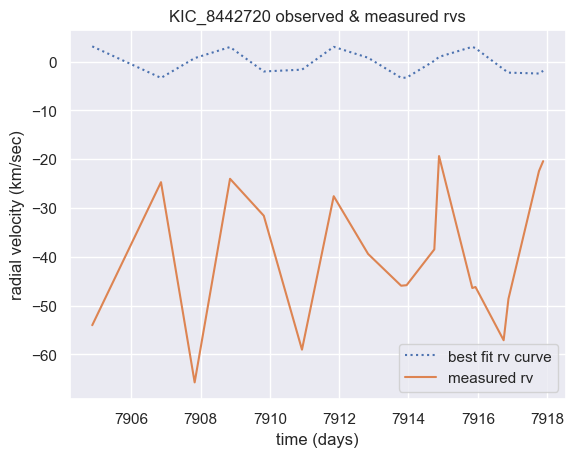

KIC target: KIC_8651471
max value is  856.3174081216799
min value is  3.119942899595912
theta value is  5.687199990866992 rad
q value is  0.025252983218498337
inclination angle value is  1.0764319414269048
Experimental p value =  [3.1199429]
Theoretical p value = 7.377758908227871
We have a binary system



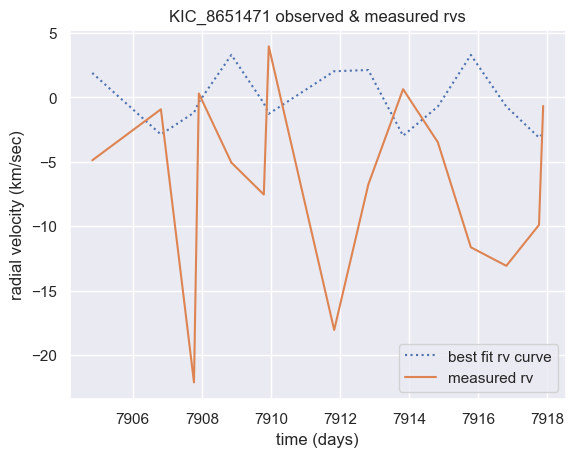

KIC target: KIC_9151271
max value is  3116.5080500579134
min value is  452.1449063876897
theta value is  3.428695000538183 rad
q value is  0.13554455419259748
inclination angle value is  1.0193406160617415
Experimental p value =  [452.14490639]
Theoretical p value = 7.377758908227871
We do not have a binary system



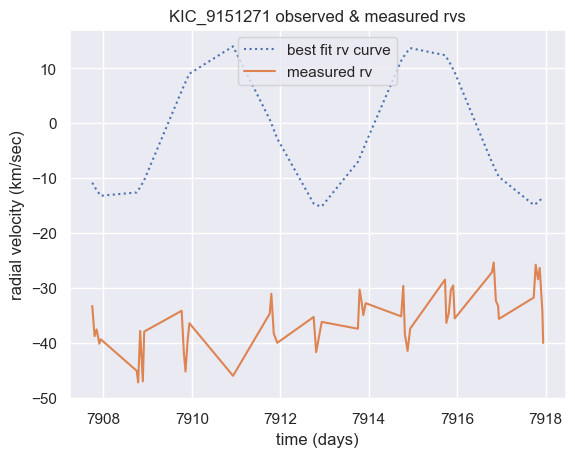

KIC target: KIC_9653110
max value is  1393.5477261098429
min value is  102.47153211290485
theta value is  1.5344364690958994 rad
q value is  0.006613168204165021
inclination angle value is  0.6669047966346509
Experimental p value =  [102.47153211]
Theoretical p value = 7.377758908227871
We do not have a binary system



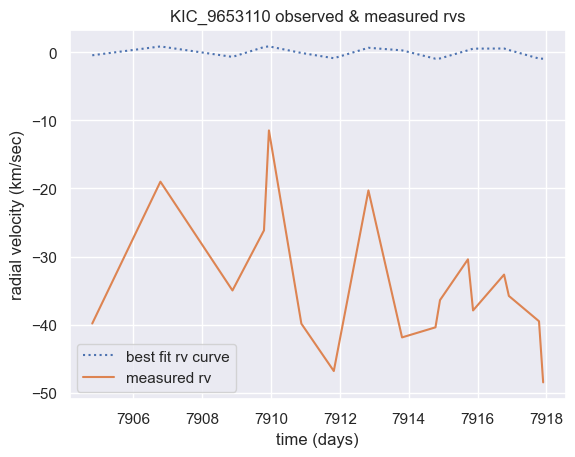

KIC target: KIC_9655045
max value is  336.56691971642505
min value is  0.010842726561260549
theta value is  1.3064755032445636 rad
q value is  0.08054236506673973
inclination angle value is  0.9709033533577888
Experimental p value =  [0.01084273]
Theoretical p value = 7.377758908227871
We have a binary system



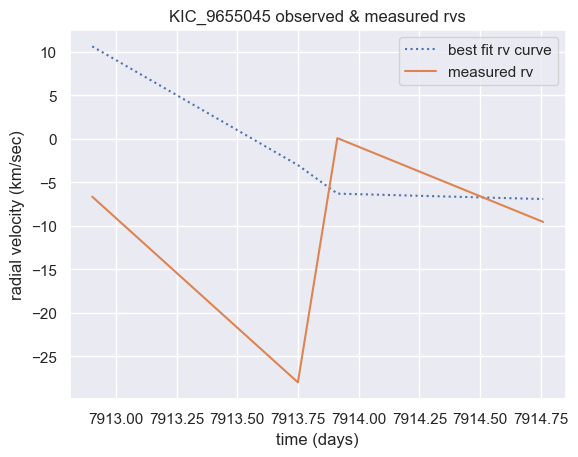

KIC target: KIC_9710336
max value is  1162.9839219915352
min value is  35.76888218541739
theta value is  2.0222282310044126 rad
q value is  0.1614244892144029
inclination angle value is  0.999342751966418
Experimental p value =  [35.76888219]
Theoretical p value = 7.377758908227871
We do not have a binary system



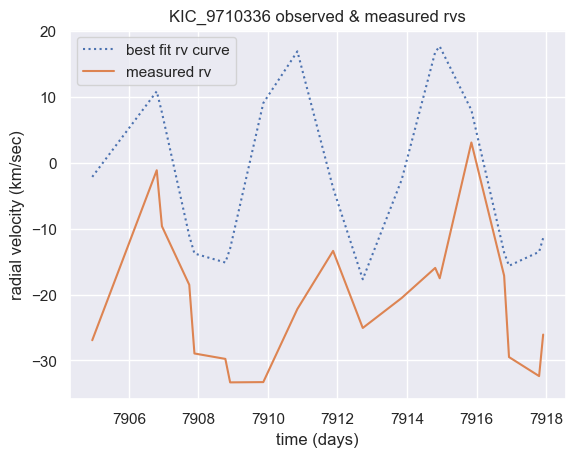

KIC target: KIC_9964938
max value is  1078.7279481735952
min value is  2.2288726860355648
theta value is  4.669544180603491 rad
q value is  0.018557820807009517
inclination angle value is  1.3406353793882684
Experimental p value =  [2.22887269]
Theoretical p value = 7.377758908227871
We have a binary system



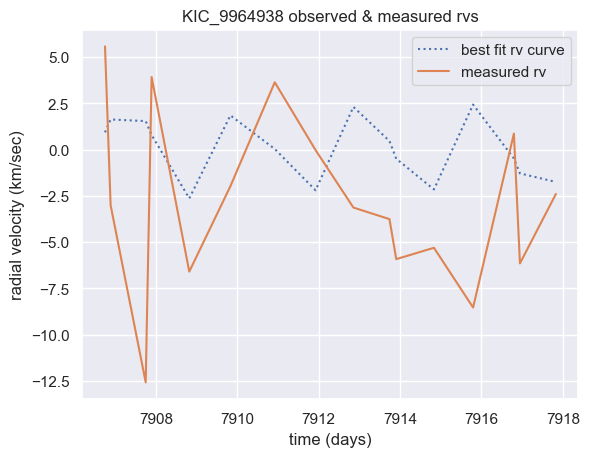

KIC target: KIC_11819949
max value is  1415.7290742459888
min value is  5.117392757321998
theta value is  0.773633805861551 rad
q value is  0.3657896104599566
inclination angle value is  0.5442185366178806
Experimental p value =  [5.11739276]
Theoretical p value = 7.377758908227871
We have a binary system



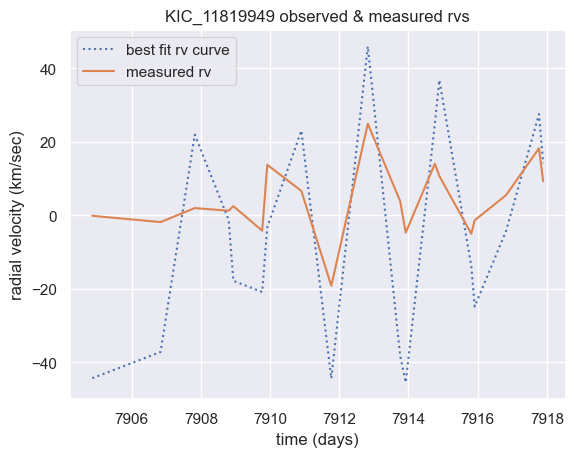

KIC target: KIC_12736892
max value is  1168.1379228161704
min value is  3.865867033933564
theta value is  6.176395331424988 rad
q value is  0.1634318662336477
inclination angle value is  0.8775653462256371
Experimental p value =  [3.86586703]
Theoretical p value = 7.377758908227871
We have a binary system



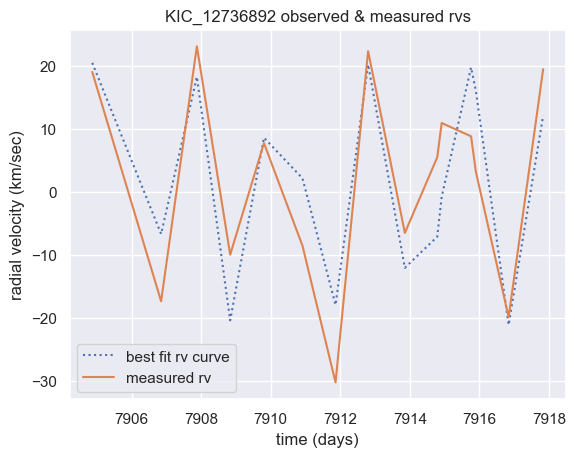

In [20]:
Binary_Model()